In [ ]:
!pip install autokeras

     |████████████████████████████████| 174kB 26.3MB/s 
     |████████████████████████████████| 71kB 10.1MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp37-none-any.whl size=78935 sha256=ac0840474f3abe7f24d1fa7d2fd1e9a1ce3da20cf371a0955bbfb1a5c7c857f3
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp37-none-any.whl size=15356 sha256=82767ddf7ff911540cacf3eeb73bddbfc3fc68fb84cfe53ab36f2b5cfad9d94c
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [ ]:
import autokeras as ak
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
from ast import literal_eval
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
book_data = pd.read_csv('/content/gdrive/My Drive/movies_metadata.csv')
credits = pd.read_csv('/content/gdrive/My Drive/credits.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
book_data.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [ ]:
book_data[['budget', 'genres', 'id', 'imdb_id', 'title', 'overview', 'popularity', 'release_date', 'revenue', 'runtime', 'status']].head()

,budget,genres,id,imdb_id,title,overview,popularity,release_date,revenue,runtime,status
0,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,tt0114709,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,1995-10-30,373554033.0,81.0,Released
1,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,tt0113497,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,1995-12-15,262797249.0,104.0,Released
2,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,tt0113228,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,1995-12-22,0.0,101.0,Released
3,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,tt0114885,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,1995-12-22,81452156.0,127.0,Released
4,0,"[{'id': 35, 'name': 'Comedy'}]",11862,tt0113041,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,1995-02-10,76578911.0,106.0,Released


In [ ]:
book_data.drop_duplicates('id', inplace=True)
book_data['id'] = pd.to_numeric(book_data['id'], errors='coerce', downcast='float')
book_data['popularity'] = pd.to_numeric(book_data['popularity'], errors='coerce', downcast='float')
book_data = pd.merge(book_data, credits, on='id', how='inner')
book_data['id'] = pd.to_numeric(book_data['id'], downcast='integer')
book_data = book_data.loc[book_data['status'] == 'Released']
titles = book_data[['title', 'id']]
book_data.drop(labels=['belongs_to_collection', 'imdb_id', 'homepage', 'overview', 
                       'poster_path', 'status', 'tagline', 'original_title', 
                       'spoken_languages', 'original_language', 'adult', 
                       'production_countries', 'production_companies', 'video', 
                       'cast', 'revenue', 'budget', 'title', 'crew'], axis=1, inplace=True)
book_data['release_date'] = pd.to_datetime(book_data['release_date'])
book_data['release_date'] = pd.DatetimeIndex(book_data.release_date).year
book_data.head()

,genres,id,popularity,release_date,runtime,vote_average,vote_count
0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,21.946943,1995.0,81.0,7.7,5415.0
1,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,17.015539,1995.0,104.0,6.9,2413.0
2,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,11.712900,1995.0,101.0,6.5,92.0
3,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,3.859495,1995.0,127.0,6.1,34.0
4,"[{'id': 35, 'name': 'Comedy'}]",11862,8.387519,1995.0,106.0,5.7,173.0


In [ ]:
m = book_data['vote_count'].quantile(0.1)
c = book_data.vote_average.mean()

In [ ]:
def weighted_rating(x, m=m, C=c):
    v = x['vote_count']
    R = x['vote_average']
    return (v / (v + m) * R) + (m / (m + v) * C)

In [ ]:
book_data['score'] = book_data.apply(weighted_rating, axis=1)
book_data.drop(labels=['vote_average', 'vote_count'], axis=1, inplace=True)

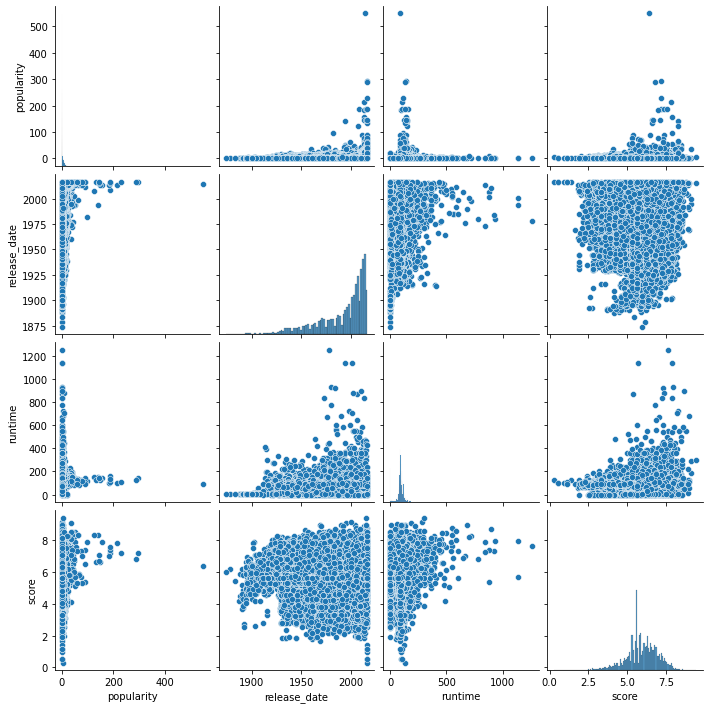

In [ ]:
sns.pairplot(book_data[['popularity', 'release_date', 'runtime', 'score']])

In [ ]:
features = ['genres']
categorical_data = book_data[features + ['id']]
categorical_data.set_index('id', inplace=True)
book_data.set_index('id', inplace=True)
book_data.drop(labels=features, axis=1, inplace=True)

In [ ]:
for feature in tqdm(features):
  categorical_data[feature] = categorical_data[feature].apply(literal_eval)

  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


In [ ]:
def get_director(x):
  for item in x:
    if item['job'] == 'Director':
      return item['name']
  return None

In [ ]:
def get_list(x, n=-1):
  if isinstance(x, list):
    names = [i['name'] for i in x]
    if n != -1:
      names = names[:n]
    if len(names) > 0:
      return names
  return None

In [ ]:
#categorical_data['director'] = categorical_data['crew'].apply(lambda x: get_director(x))
categorical_data['genres'] = categorical_data['genres'].apply(lambda x: get_list(x))
#categorical_data['cast'] = categorical_data['cast'].apply(lambda x: get_list(x, 3))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
categorical_data = pd.concat([categorical_data, categorical_data['genres'].str.join(sep='|').str.get_dummies(sep='|')], axis=1)
#categorical_data = pd.concat([categorical_data, categorical_data['cast'].str.join(sep='|').str.get_dummies(sep='|')], axis=1)
#categorical_data = pd.get_dummies(categorical_data, columns=['director'])

In [ ]:
categorical_data.dropna(inplace=True)
categorical_data.drop(labels='genres', axis=1, inplace=True)

In [ ]:
book_data.drop(labels=['score', 'popularity'], axis=1, inplace=True)
book_data.dropna(inplace=True)

In [ ]:
book_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44709 entries, 862 to 461257
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   release_date  44709 non-null  float64
 1   runtime       44709 non-null  float64
dtypes: float64(2)
memory usage: 1.0 MB


In [ ]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(book_data)
scaled_df = pd.DataFrame(scaled_data, columns=['release_year', 'runtime'], index=book_data.index)

In [ ]:
scaled_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44709 entries, 862 to 461257
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   release_year  44709 non-null  float64
 1   runtime       44709 non-null  float64
dtypes: float64(2)
memory usage: 1.0 MB


In [ ]:
book_data = pd.merge(scaled_df, categorical_data, on='id')

In [ ]:
ratings = pd.read_csv('/content/gdrive/My Drive/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


In [ ]:
ratings['take_flg'] = ratings['movieId'].apply(lambda x: x in book_data.index)
ratings = ratings.loc[ratings['take_flg'] == True]
ratings.drop(labels=['timestamp', 'take_flg'], axis=1, inplace=True)

In [ ]:
ratings.head()

,userId,movieId,rating
0,1,110,1.0
1,1,147,4.5
2,1,858,5.0
4,1,1246,5.0
5,1,1968,4.0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


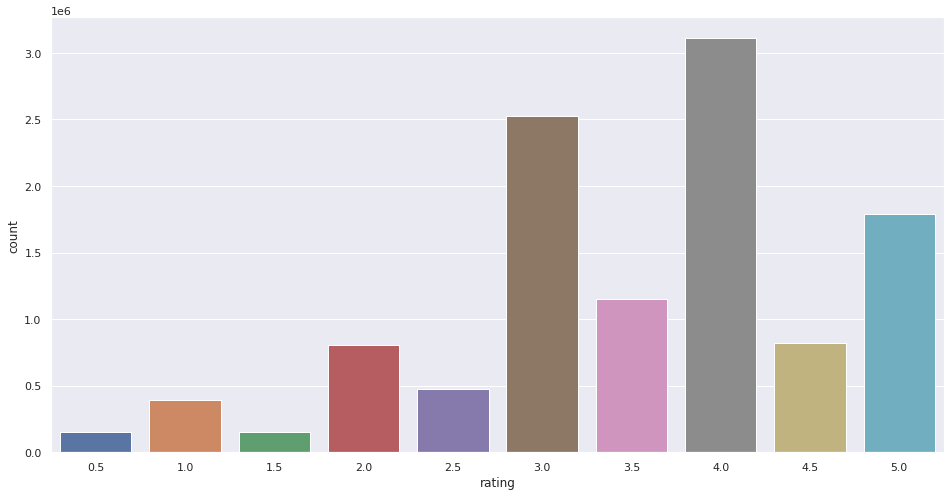

In [ ]:
fig = plt.figure(figsize=(16, 8))
sns.set()
sns.countplot(ratings.rating)
plt.show()

In [ ]:
from keras.layers import Concatenate, Dense, Dropout, Input, Reshape, Dot, Activation, Lambda
from keras.models import Model
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

In [ ]:
data = ratings.sample(frac=0.01)

In [ ]:
user_enc = LabelEncoder()
data['user'] = user_enc.fit_transform(data['userId'].values)
n_users = data['user'].nunique()

item_enc = LabelEncoder()
data['movie'] = item_enc.fit_transform(data['movieId'].values)
n_movies = data['movie'].nunique()

data['rating'] = data['rating'].values.astype(np.float32)
min_rating = min(data['rating'])
max_rating = max(data['rating'])
data['rating'] = (data['rating'] - min_rating) / (max_rating - min_rating)
n_users, n_movies, min_rating, max_rating

(66934, 3561, 0.5, 5.0)

In [ ]:
data.head()

,userId,movieId,rating,user,movie
22233826,230786,858,1.000000,57187,594
25330469,263700,2335,0.555556,65214,1285
20864997,216844,49957,1.000000,53750,2935
22760299,236517,1833,0.333333,58543,979
9210131,95108,1266,0.777778,23639,739


In [ ]:
X = data[['user', 'movie']].values
y = data['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((79588, 2), (34110, 2), (79588,), (34110,))

In [ ]:
n_factors = 50
#X_train_array = np.array([X_train[:, 0], X_train[:, 1]])
#X_test_array = np.array([X_test[:, 0], X_test[:, 1]])

In [ ]:
"""
class EmbeddingLayer:
    def __init__(self, n_items, n_factors):
        self.n_items = n_items
        self.n_factors = n_factors
    
    def __call__(self, x):
        x = Embedding(self.n_items, self.n_factors, embeddings_initializer='he_normal',
                      embeddings_regularizer=l2(1e-6))(x)
        x = Reshape((self.n_factors,))(x)
        return x
"""

In [ ]:
"""
def RecommenderNet(n_users, n_movies, n_factors, min_rating, max_rating):
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user)
    
    movie = Input(shape=(1,))
    m = EmbeddingLayer(n_movies, n_factors)(movie)
    
    x = Concatenate()([u, m])
    x = Dropout(0.05)(x)
    
    x = Dense(10, kernel_initializer='he_normal')(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)
    model = Model(inputs=[user, movie], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)
    return model
"""

In [ ]:
class RecommenderNet(Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=l2(1e-6),
        )
        self.user_bias = Embedding(num_users, 1)
        self.movie_embedding = Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=l2(1e-6),
        )
        self.movie_bias = Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)

In [ ]:
model = RecommenderNet(n_users, n_movies, n_factors)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
              metrics=['mse', 'mae'],
              optimizer=Adam(lr=0.001)
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
history = model.fit(x=X_train, y=y_train, batch_size=64, epochs=10,
                    verbose=1, validation_data=(X_test, y_test))

Epoch 1/10
2416/2416 [==============================] - 100s 35ms/step - loss: 0.6759 - mse: 0.0776 - val_loss: 0.6246 - val_mse: 0.0514
Epoch 2/10
2416/2416 [==============================] - 85s 35ms/step - loss: 0.6503 - mse: 0.0586 - val_loss: 0.6415 - val_mse: 0.0587
Epoch 3/10
2416/2416 [==============================] - 84s 35ms/step - loss: 0.6194 - mse: 0.0491 - val_loss: 0.6392 - val_mse: 0.0568
Epoch 4/10
2416/2416 [==============================] - 84s 35ms/step - loss: 0.6254 - mse: 0.0502 - val_loss: 0.6422 - val_mse: 0.0574
Epoch 5/10
2416/2416 [==============================] - 85s 35ms/step - loss: 0.6345 - mse: 0.0533 - val_loss: 0.6419 - val_mse: 0.0565
Epoch 6/10
2416/2416 [==============================] - 86s 35ms/step - loss: 0.6415 - mse: 0.0552 - val_loss: 0.6425 - val_mse: 0.0561
Epoch 7/10
2416/2416 [==============================] - 86s 35ms/step - loss: 0.6436 - mse: 0.0551 - val_loss: 0.6424 - val_mse: 0.0554
Epoch 8/10
2416/2416 [=========================

In [ ]:
unique, counts = np.unique(X_train[:, 0], return_counts=True)
d = dict(zip(unique, counts))
sorted(d.items(), key=lambda x: -x[1])[:5]

[(3001, 53), (16063, 47), (63196, 45), (24856, 41), (37832, 40)]

In [ ]:
def get_recommendation(user_id):
  for_present = np.vstack((np.array([user_id] * n_movies), np.arange(n_movies))).T
  for_present = pd.DataFrame(for_present, columns=['user', 'movie'])
  for_present['rating'] = model.predict(for_present) * 4.5 + .5
  for_present['watched'] = for_present['movie'].apply(lambda x: 1 if x in X_train[X_train[:, 0] == user_id][:, 1] else 0)
  for_present = for_present.loc[for_present['watched'] == 0].sort_values('rating', ascending=False)
  for_present['new_movie'] = item_enc.inverse_transform(for_present['movie'])
  return for_present.merge(titles, left_on='new_movie', right_on='id')[['title', 'rating']].head(10)

In [ ]:
get_recommendation(16063)

,title,rating
0,The Thomas Crown Affair,4.512583
1,Sleepless in Seattle,4.439126
2,Dead Man,4.432932
3,Galaxy Quest,4.421992
4,Dr. Jekyll and Mr. Hyde,4.398705
5,Dawn of the Dead,4.383472
6,Gremlins 2: The New Batch,4.368866
7,Solaris,4.360071
8,Beetlejuice,4.359638
9,The Thomas Crown Affair,4.350326


In [ ]:
history.history

{'loss': [0.6564590930938721,
  0.6260020136833191,
  0.6174732446670532,
  0.6216855645179749,
  0.6303727030754089,
  0.6359187364578247,
  0.6403518915176392,
  0.645333468914032,
  0.6491097807884216,
  0.650198757648468],
 'mse': [0.06787654757499695,
  0.051403697580099106,
  0.047845277935266495,
  0.0487261638045311,
  0.05140313133597374,
  0.05281655117869377,
  0.05394638329744339,
  0.05508928373456001,
  0.056244801729917526,
  0.05479913577437401],
 'val_loss': [0.6246057748794556,
  0.6414551734924316,
  0.6391817927360535,
  0.6422388553619385,
  0.6419363021850586,
  0.6425125002861023,
  0.6424057483673096,
  0.6439620852470398,
  0.6428512930870056,
  0.6461243629455566],
 'val_mse': [0.051439814269542694,
  0.05866432934999466,
  0.05676838383078575,
  0.05739493668079376,
  0.05649062618613243,
  0.05606994032859802,
  0.05535978823900223,
  0.05549202859401703,
  0.054379649460315704,
  0.05546245723962784]}

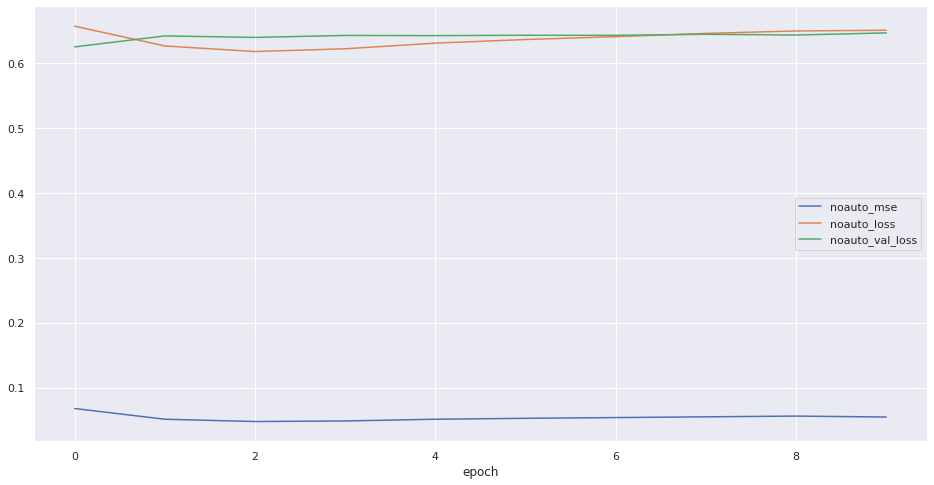

In [ ]:
fig=plt.figure(figsize=(16,8))
sns.set()
plt.plot(history.history['mse'], label='noauto_mse')
plt.plot(history.history['loss'], label='noauto_loss')
plt.plot(history.history['val_loss'], label='noauto_val_loss')
plt.legend()
plt.xlabel('epoch')
plt.show()

In [ ]:
user = ak.Input()
u = ak.Embedding(n_users)(user)
#u = Embedding(n_users,n_factors,embeddings_initializer="he_normal",embeddings_regularizer=l2(1e-6))(user)

movie = ak.Input()
m = ak.Embedding(n_movies)(movie)
#m = Embedding(n_movies, n_factors, embeddings_initializer="he_normal", embeddings_regularizer=l2(1e-6))(movie)

x = ak.Merge('concatenate')([u, m])
x = ak.DenseBlock()(x)
regression_output = ak.RegressionHead()(x)


auto_model = ak.AutoModel(inputs=[user, movie],
                          outputs=regression_output, 
                          overwrite=True,
                          seed=42,
                          loss='binary_crossentropy',
                          tuner='greedy',
                          metrics=['mse'],
                          max_trials=6)

In [ ]:
auto_history = auto_model.fit(
    x=(X_train[:, 0], X_train[:, 1]),
    y=y_train,
    batch_size=64,
    epochs=1,
    validation_data=((X_test[:, 0], X_test[:, 1]), y_test)
    )

Trial 6 Complete [00h 01m 42s]
val_loss: 0.6138266921043396

Best val_loss So Far: 0.6132068037986755
Total elapsed time: 00h 12m 20s
INFO:tensorflow:Oracle triggered exit
1244/1244 [==============================] - 101s 81ms/step - loss: 0.6554 - mse: 0.0629 - val_loss: 0.6141 - val_mse: 0.0485
INFO:tensorflow:Assets written to: ./auto_model/best_model/assets


In [ ]:
m = auto_model.export_model()

In [ ]:
m.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
cast_to_float32 (CastToFloat32) (None,)              0           input_1[0][0]                    
__________________________________________________________________________________________________
cast_to_float32_1 (CastToFloat3 (None,)              0           input_2[0][0]                    
______________________________________________________________________________________________

In [ ]:
def get_recommendation_v2(user_id):
  for_present = np.vstack((np.array([user_id] * n_movies), np.arange(n_movies))).T
  for_present = pd.DataFrame(for_present, columns=['user', 'movie'])
  X = for_present[['user', 'movie']].values
  rates = auto_model.predict((X[:, 0], X[:, 1])) * 4.5 + .5
  for_present['rating'] = rates
  for_present['watched'] = for_present['movie'].apply(lambda x: 1 if x in X_train[X_train[:, 0] == user_id][:, 1] else 0)
  for_present = for_present.loc[for_present['watched'] == 0].sort_values('rating', ascending=False)
  for_present['new_movie'] = item_enc.inverse_transform(for_present['movie'])
  return for_present.merge(titles, left_on='new_movie', right_on='id')[['title', 'rating']].head(10)

In [ ]:
get_recommendation_v2(16063)#3001

245/245 [==============================] - 0s 1ms/step


,title,rating
0,The Million Dollar Hotel,4.710243
1,The Soft Skin,4.513959
2,The Talented Mr. Ripley,4.508007
3,Hard Target,4.499407
4,Hannibal Rising,4.495997
5,"Farewell, Friend",4.479396
6,The Good Thief,4.453622
7,The Sixth Sense,4.446445
8,Edward Scissorhands,4.422431
9,Miami Vice,4.414167


In [ ]:
get_recommendation_v2(3001)

245/245 [==============================] - 0s 1ms/step


,title,rating
0,The Million Dollar Hotel,4.573888
1,The Talented Mr. Ripley,4.355257
2,Hard Target,4.318328
3,Hannibal Rising,4.295158
4,The Sixth Sense,4.289175
5,"Farewell, Friend",4.287578
6,The Soft Skin,4.286912
7,Sleepless in Seattle,4.232269
8,Miami Vice,4.232214
9,"A Woman, a Gun and a Noodle Shop",4.228520


In [ ]:
#binary_crossentropy
auto_history_greedy = {
    "val_loss": [0.61, 0.61, 0.61, 0.6102, 0.6111, 0.609, 0.608, 0.607],
    "val_mse": [0.049, 0.0463, 0.046, 0.04654, 0.0469, 0.0489, 0.05, 0.0495]
    }

auto_history_bayesian = {
    "val_loss": [0.61, 0.605, 0.615, 0.6, 0.605, 0.599, 0.600, 0.609],
    "val_mse": [0.05, 0.0461, 0.0449, 0.05, 0.0473, 0.0471, 0.0443, 0.0437]
    }

auto_history_random = {
    "val_loss": [0.64, 0.65, 0.661, 0.69, 0.633, 0.629, 0.611, 0.68],
    "val_mse": [0.062, 0.056, 0.0524, 0.061, 0.053, 0.064, 0.0521, 0.063]
    }

In [ ]:
for i in range(8):
  print(min(auto_history_bayesian['val_mse'][i], min(auto_history_random['val_mse'][i], auto_history_greedy['val_mse'][i])))

0.049
0.0461
0.0449
0.04654
0.0469
0.0471
0.0443
0.0437


In [ ]:
x_axis=['auto_model_1',
        'auto_model_2',
        'auto_model_3',
        'auto_model_4',
        'auto_model_5',
        'auto_model_6',
        'auto_model_7',
        'auto_model_8'
        ]

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


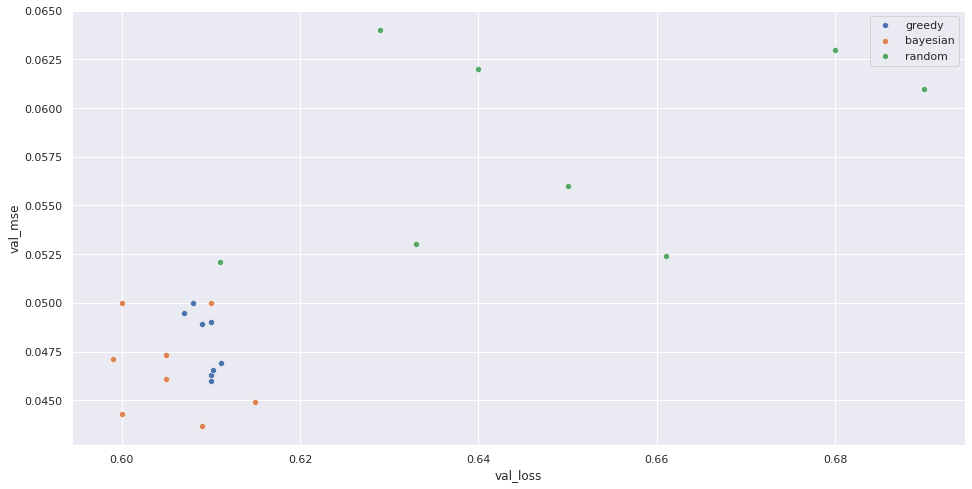

In [ ]:
fig=plt.figure(figsize=(16,8))
sns.set()
sns.scatterplot(auto_history_greedy['val_loss'], auto_history_greedy['val_mse'], label='greedy')
sns.scatterplot(auto_history_bayesian['val_loss'], auto_history_bayesian['val_mse'], label='bayesian')
sns.scatterplot(auto_history_random['val_loss'], auto_history_random['val_mse'], label='random')
plt.xlabel('val_loss')
plt.ylabel('val_mse')
plt.show()

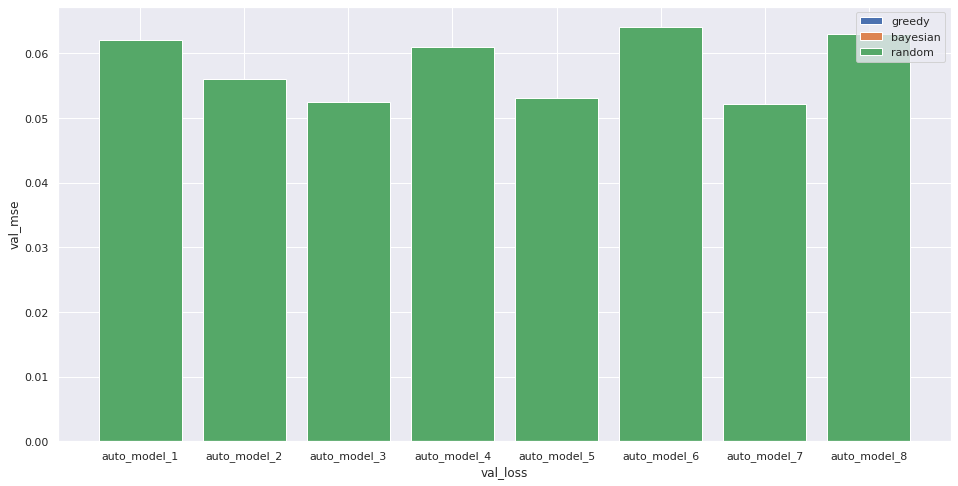

In [ ]:
fig=plt.figure(figsize=(16,8))
plt.bar(x_axis, auto_history_greedy['val_mse'], label='greedy')
plt.bar(x_axis, auto_history_bayesian['val_mse'], label='bayesian')
plt.bar(x_axis, auto_history_random['val_mse'], label='random')
plt.xlabel('val_loss')
plt.ylabel('val_mse')
plt.legend()
plt.show()